# Importing Libraries

In [1]:
!pip install nltk afinn
!pip install -upgrade gspread


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -u


In [2]:
import pandas as pd
import numpy as np
import requests
import gspread
import nltk
import re
import string
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
from wordcloud import WordCloud
from afinn import Afinn
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.corpus import sentiwordnet as swn
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler
from google.oauth2.service_account import Credentials
from google.colab import drive
from google.colab import auth
drive.mount('/content/drive')
auth.authenticate_user()
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('sentiwordnet')
nltk.download('averaged_perceptron_tagger_eng')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

# Load Dataset & Cleaning Dataset

In [3]:
# Scope access for Google Sheets and Google Drive to grant permission to access Google Sheets and Drive files
scope_gsheet = ['https://www.googleapis.com/auth/drive','https://www.googleapis.com/auth/spreadsheets.readonly']
creds_gsheet = Credentials.from_service_account_file('/content/drive/MyDrive/Sentiment Analysis/dimas-projects-435309-8d1138031d49.json', scopes=scope_gsheet)
conn_gsheet = gspread.authorize(creds_gsheet)

sheet = conn_gsheet.open('Data_Trending_Topic_DeepSeek').sheet1

data = pd.DataFrame(sheet.get_all_records())
data.head()

,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username
0,1.884490e+23,Wed Jan 29 06:42:23 +0000 2025,0,Gila udah ada course nya DeepSeek-R1 Crash Cou...,1.884490e+23,,,in,Menara Gading,0,0,0,https://x.com/lumen_stardust/status/1884492267...,1.043820e+23,lumen_stardust
1,1.884480e+23,Wed Jan 29 06:41:52 +0000 2025,1,@NickVesting bisa sentimen buruk ada sesuatu y...,1.884490e+23,,NickVesting,in,Indonesia,1,0,0,https://x.com/TradingDiary2/status/18844921374...,1.260800e+22,TradingDiary2
2,1.884490e+23,Wed Jan 29 06:41:11 +0000 2025,0,HOLAAA!!! YANG BUTUH APP PREM AKU READY &amp; ...,1.884490e+23,https://pbs.twimg.com/media/GicPT-hbsAARmo-.jpg,,in,"avail qris, wa:",0,1,0,https://x.com/nvoticed/status/1884491963883471124,3.285955e+09,nvoticed
3,1.884230e+23,Wed Jan 29 06:40:39 +0000 2025,0,@PandaMerahku @ihsnjn @primawansatrio Kak maaf...,1.884490e+23,,PandaMerahku,in,,0,0,0,https://x.com/syguti171147/status/188449183341...,1.767180e+23,syguti171147
4,1.884490e+23,Wed Jan 29 06:39:27 +0000 2025,0,Deepseek udh jadi pembicaraan utama di pertemu...,1.884490e+23,,,in,Bogor,0,0,0,https://x.com/YehezGun/status/1884491531492741459,7.249515e+08,YehezGun


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3225 entries, 0 to 3224
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   conversation_id_str      3225 non-null   float64
 1   created_at               3225 non-null   object 
 2   favorite_count           3225 non-null   int64  
 3   full_text                3225 non-null   object 
 4   id_str                   3225 non-null   float64
 5   image_url                3225 non-null   object 
 6   in_reply_to_screen_name  3225 non-null   object 
 7   lang                     3225 non-null   object 
 8   location                 3225 non-null   object 
 9   quote_count              3225 non-null   int64  
 10  reply_count              3225 non-null   int64  
 11  retweet_count            3225 non-null   int64  
 12  tweet_url                3225 non-null   object 
 13  user_id_str              3225 non-null   float64
 14  username                

In [5]:
# Selected only essential columns for sentimental analysis.
data_scrape = data[['created_at', 'full_text', 'username']].rename(columns={'created_at': 'Date', 'full_text': 'Tweet', 'username': 'Username'}).drop_duplicates()
data_scrape.head()

,Date,Tweet,Username
0,Wed Jan 29 06:42:23 +0000 2025,Gila udah ada course nya DeepSeek-R1 Crash Cou...,lumen_stardust
1,Wed Jan 29 06:41:52 +0000 2025,@NickVesting bisa sentimen buruk ada sesuatu y...,TradingDiary2
2,Wed Jan 29 06:41:11 +0000 2025,HOLAAA!!! YANG BUTUH APP PREM AKU READY &amp; ...,nvoticed
3,Wed Jan 29 06:40:39 +0000 2025,@PandaMerahku @ihsnjn @primawansatrio Kak maaf...,syguti171147
4,Wed Jan 29 06:39:27 +0000 2025,Deepseek udh jadi pembicaraan utama di pertemu...,YehezGun


In [6]:
data_scrape.dropna()
print(f"Check data is null: {data_scrape.isnull().sum().sum()}")
print(f"Check data is duplicate: {data_scrape.duplicated().sum().sum()}")

Check data is null: 0
Check data is duplicate: 0


In [7]:
print(f"Number of raw data: {data_scrape.shape[0]}")
print(f"Number of columns data: {data_scrape.shape[1]}")

Number of raw data: 2561
Number of columns data: 3


# Data Preprocessing

In [8]:
# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('indonesian'))
lemmatizer = WordNetLemmatizer()

# Adding stopwords from external sources
stopword_path = '/content/drive/MyDrive/Sentiment Analysis/stopwordbahasa.csv'
stopword_bahasa = pd.read_csv(stopword_path, encoding='latin-1')
stopword_bahasa.columns = ['Stopword']

# Adding idiom words for normalized words
kamus_idiom_path = '/content/drive/MyDrive/Sentiment Analysis/kamus_idiom.csv'
kamus_idiom = pd.read_csv(kamus_idiom_path, encoding='latin-1')
kamus_idiom.columns = ['Original', 'Replacement']
kamus_idiom_map = dict(zip(kamus_idiom['Original'], kamus_idiom['Replacement']))

# Add shortened words for word normalization
kamus_singkatan_path = '/content/drive/MyDrive/Sentiment Analysis/kamus_singkatan.csv'
kamus_singkatan = pd.read_csv(kamus_singkatan_path, sep=';', encoding='latin-1')
kamus_singkatan.columns = ['Original', 'Replacement']
kamus_singkatan_map = dict(zip(kamus_singkatan['Original'], kamus_singkatan['Replacement']))

In [9]:
def preprocess_text(text):
    # Cleaning: remove URLs, special characters, numbers
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # Remove mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # Remove hashtag
    text = re.sub(r'RT[\s]', '', text) # Remove RT
    text = re.sub(r'[0-9]+', '', text) # Remove number
    text = re.sub(r'[^\w\s]', '', text) # Remove character besides letters and number
    text = text.replace('\n', ' ') # replace new line with space
    text = text.translate(str.maketrans('', '', string.punctuation)) # Remove all punctuation
    text = text.strip(' ') # Remove character spaces from the left and right of the text

    # Case folding: convert to lowercase
    text = text.lower()

    # Tokenization
    words_tokens = word_tokenize(text)

    # Filtering: remove stopwords
    stop_words.update(stopword_bahasa['Stopword'].tolist())
    words = [word for word in words_tokens if word not in stop_words]

    # Normalize idiom text
    normalized_text = ' '.join([kamus_idiom_map[word] if word in kamus_idiom_map else word for word in words])

    # Normalize shortened words
    normalized_text = ' '.join([kamus_singkatan_map[word] if word in kamus_singkatan_map else word for word in normalized_text.split()])

    # Lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]

    return " ".join(words)

# Apply preprocessing to the 'Cleaned_Tweet' column
data_scrape['Cleaned_Tweet'] = data_scrape['Tweet'].apply(preprocess_text)

# Display the first few rows of Cleaned_Tweet
data_scrape.head()

,Date,Tweet,Username,Cleaned_Tweet
0,Wed Jan 29 06:42:23 +0000 2025,Gila udah ada course nya DeepSeek-R1 Crash Cou...,lumen_stardust,gila udah course nya deepseekr crash course vi...
1,Wed Jan 29 06:41:52 +0000 2025,@NickVesting bisa sentimen buruk ada sesuatu y...,TradingDiary2,nickvesting sentimen buruk yg ga enak yg menek...
2,Wed Jan 29 06:41:11 +0000 2025,HOLAAA!!! YANG BUTUH APP PREM AKU READY &amp; ...,nvoticed,holaaa butuh app prem ready amp full garansi k...
3,Wed Jan 29 06:40:39 +0000 2025,@PandaMerahku @ihsnjn @primawansatrio Kak maaf...,syguti171147,pandamerahku ihsnjn primawansatrio kak maaf je...
4,Wed Jan 29 06:39:27 +0000 2025,Deepseek udh jadi pembicaraan utama di pertemu...,YehezGun,deepseek udh pembicaraan utama pertemuan kelua...


In [10]:
# Intialize VADER
vader_analyzer = SentimentIntensityAnalyzer()

# Initialize AFINN
afinn_analyzer = Afinn()

# Convert Treebank POS (Part-of-Speech) tags into POS tags used by WordNet (for lemmatization)
def get_wordnet_pos(treebank_tag):
  if treebank_tag.startswith('J'):
    return wordnet.ADJ
  elif treebank_tag.startswith('V'):
    return wordnet.VERB
  elif treebank_tag.startswith('N'):
    return wordnet.NOUN
  elif treebank_tag.startswith('R'):
    return wordnet.ADV
  else:
    return None

# Function to calculate the sentiment score using the VADER model
def vader_sentiment(text):
  vader_score = vader_analyzer.polarity_scores(text)
  return vader_score['compound']

# Function to calculate sentiment score using AFINN model
def afinn_sentiment(text):
  return afinn_analyzer.score(text)

# Function to calculate sentiment score using SentiWordNet
def sentiwordnet_sentiment(text):
  words_token = word_tokenize(text)
  pos_tags = pos_tag(words_token)

  positive_score = 0
  negative_score = 0

  # Iterations for each word and POS tag to analyze sentiment
  for word, pos in pos_tags:
    wordnet_pos = get_wordnet_pos(pos)
    # If the POS tag is valid, perform lemmatization on the word
    if wordnet_pos:
      lemma = lemmatizer.lemmatize(word, pos=wordnet_pos)
      senti_synsets = list(swn.senti_synsets(lemma, wordnet_pos))

      # If synset is found, take the first synset for sentiment analysis
      if senti_synsets:
        # Take the first synset
        senti_synset = senti_synsets[0]
        positive_score += senti_synset.pos_score()
        negative_score += senti_synset.neg_score()

  # Calculate the final score as the difference between positive and negative
  return positive_score - negative_score

negation_words = ['tidak', 'bukan', 'kurang', 'belum', 'jangan', 'ga', 'nggak', 'capek', 'cape', 'ngaco', 'heran',
                'parah', 'tak','nih','gabisa','kagak', 'kok', 'aneh', 'jelek','kesel', 'aneh', 'benci', 'jlk', 'gjls', 'payah', 'gabisa',
                'ga bener', 'lemot', 'lama']

# Function to adjust the sentiment score based on the negation word in the text
def adjust_for_negation(text, sentiment_score):
  words = text.split()
  for word in words:
    if word in negation_words:
      sentiment_score *= -1
  return sentiment_score

# Function to calculate the combined sentiment score of multiple analysis methods
def combined_sentiment(text):
  # Calculate in every lexicon
  vader_score = vader_sentiment(text)
  afinn_score = afinn_sentiment(text)
  sentiwordnet_score = sentiwordnet_sentiment(text)

  # Combine score by giving more weight to SntiWordNet
  combined_score = (vader_score + afinn_score + 2 * sentiwordnet_score) / 4

  # Adjust for negation
  combined_score = adjust_for_negation(text, combined_score)

  return combined_score

# Function to get a label from text
def get_sentiment_label(text):
  combined_score = combined_sentiment(text)

  if combined_score > 0:
    return 'Positive'
  elif combined_score < 0:
    return 'Negative'
  else:
    return 'Neutral'


# Apply function get_polarity to the column 'Cleaned_Tweet' dan create new column 'Polarity'
data_scrape['Polarity'] = data_scrape['Cleaned_Tweet'].apply(get_sentiment_label)

# Check data after adding new column
data_scrape.head()

,Date,Tweet,Username,Cleaned_Tweet,Polarity
0,Wed Jan 29 06:42:23 +0000 2025,Gila udah ada course nya DeepSeek-R1 Crash Cou...,lumen_stardust,gila udah course nya deepseekr crash course vi...,Negative
1,Wed Jan 29 06:41:52 +0000 2025,@NickVesting bisa sentimen buruk ada sesuatu y...,TradingDiary2,nickvesting sentimen buruk yg ga enak yg menek...,Positive
2,Wed Jan 29 06:41:11 +0000 2025,HOLAAA!!! YANG BUTUH APP PREM AKU READY &amp; ...,nvoticed,holaaa butuh app prem ready amp full garansi k...,Positive
3,Wed Jan 29 06:40:39 +0000 2025,@PandaMerahku @ihsnjn @primawansatrio Kak maaf...,syguti171147,pandamerahku ihsnjn primawansatrio kak maaf je...,Positive
4,Wed Jan 29 06:39:27 +0000 2025,Deepseek udh jadi pembicaraan utama di pertemu...,YehezGun,deepseek udh pembicaraan utama pertemuan kelua...,Neutral


# Visualize Data

Check distribution of Polarity: 
Polarity
Neutral     1660
Positive     488
Negative     413
Name: count, dtype: int64


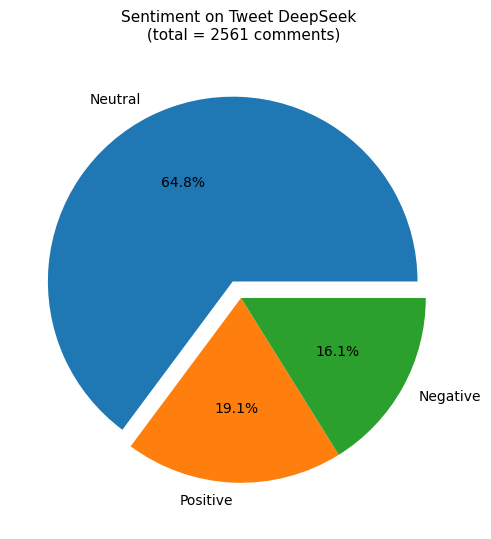

In [11]:
print(f"Check distribution of Polarity: \n{data_scrape['Polarity'].value_counts()}")

fig, ax = plt.subplots(figsize = (6, 6))
sizes = [count for count in data_scrape['Polarity'].value_counts()]
labels = list(data_scrape['Polarity'].value_counts().index)
explode = (0.1, 0, 0)
ax.pie(x = sizes, labels = labels, autopct = '%1.1f%%', explode = explode, textprops={'fontsize': 10})
ax.set_title('Sentiment on Tweet DeepSeek \n (total = 2561 comments)', fontsize = 11, pad = 20)
plt.show()

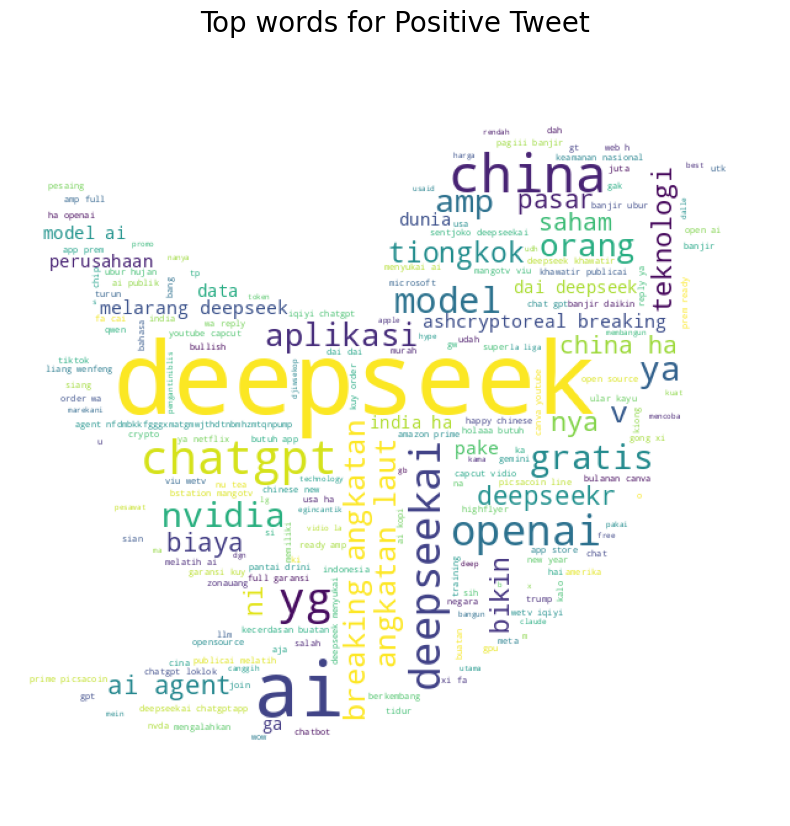

In [12]:
# Get a tamplate for visualize WorldCloud
url = "https://image.freepik.com/free-icon/twitter-logo_318-40459.jpg"
response = requests.get(url)
twitter_mask = np.array(Image.open(BytesIO(response.content)))

# Create WordCloud
wc = WordCloud(
    background_color='white',
    max_words=200,
    mask=twitter_mask,
)

# Generate WordCloud from Positive
wc.generate(' '.join(text for text in data_scrape.loc[data_scrape['Polarity'] == 'Positive', 'Cleaned_Tweet']))

# Display WordCloud
plt.figure(figsize=(18,10))
plt.title('Top words for Positive Tweet', fontdict={'size': 20,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

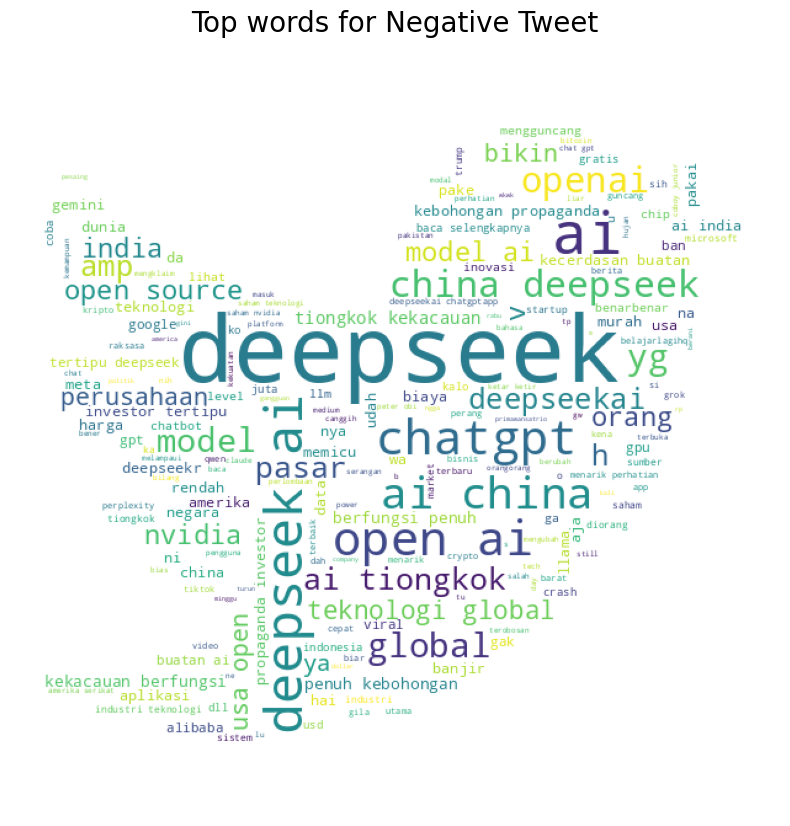

In [13]:
# Generate WordCloud from Negative
wc.generate(' '.join(text for text in data_scrape.loc[data_scrape['Polarity'] == 'Negative', 'Cleaned_Tweet']))

# Display WordCloud
plt.figure(figsize=(18,10))
plt.title('Top words for Negative Tweet', fontdict={'size': 20,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

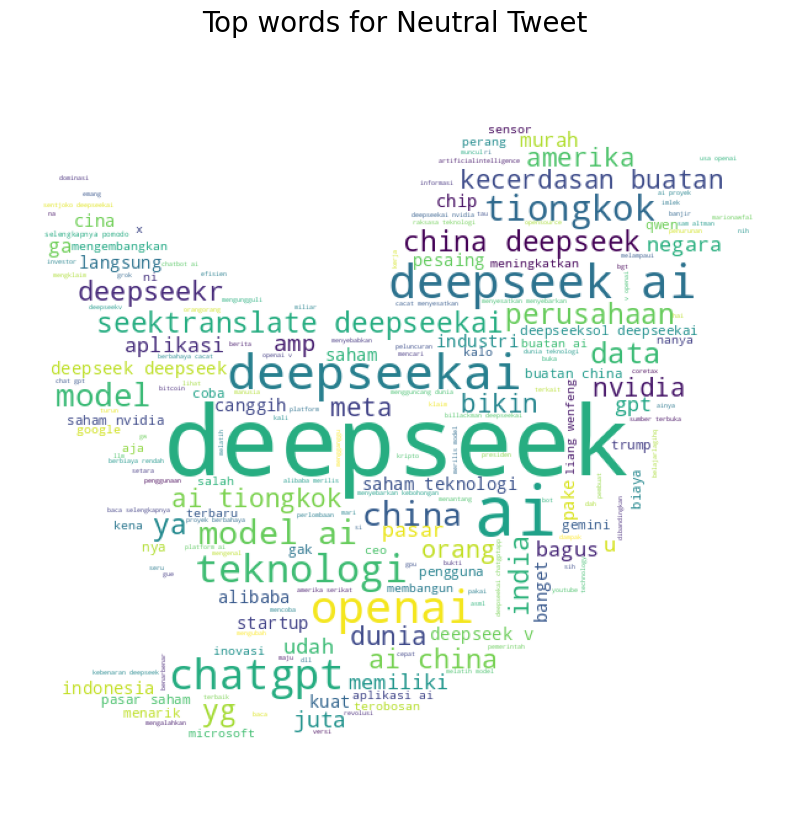

In [14]:
# Generate WordCloud from Neutral
wc.generate(' '.join(text for text in data_scrape.loc[data_scrape['Polarity'] == 'Neutral', 'Cleaned_Tweet']))

# Display WordCloud
plt.figure(figsize=(18,10))
plt.title('Top words for Neutral Tweet', fontdict={'size': 20,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

# Data Balancing, Data Splitting, & Feature Ekstraction with TF-IDF

In [15]:
X = data_scrape['Cleaned_Tweet']
y = data_scrape['Polarity']

# Create oversampling
oversampling = RandomOverSampler(sampling_strategy='minority')
X_res, y_res = oversampling.fit_resample(X.values.reshape(-1, 1), y)

# Update DataFrame with resampled data
data_scrape_balanced = pd.DataFrame({'Cleaned_Tweet': X_res.flatten(), 'Polarity': y_res})
data_scrape_balanced.head()

,Cleaned_Tweet,Polarity
0,gila udah course nya deepseekr crash course vi...,Negative
1,nickvesting sentimen buruk yg ga enak yg menek...,Positive
2,holaaa butuh app prem ready amp full garansi k...,Positive
3,pandamerahku ihsnjn primawansatrio kak maaf je...,Positive
4,deepseek udh pembicaraan utama pertemuan kelua...,Neutral


In [16]:
tfidf_vectorizer = TfidfVectorizer(max_features=500, min_df=17, max_df=0.8)

# Fit and transform data "Cleaned_Tweet" into TF-IDF matrix
X_tfidf = tfidf_vectorizer.fit_transform(data_scrape_balanced['Cleaned_Tweet'])

# Check shape dimension of TF-IDF matrix
print(f"Shape of TF-IDF matrix: {X_tfidf.shape}")

Shape of TF-IDF matrix: (3808, 465)


In [17]:
X = X_tfidf
y = data_scrape_balanced['Polarity']

# Spilt training & testing (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Display the dimension set train and test
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (3046, 465)
Shape of X_test: (762, 465)
Shape of y_train: (3046,)
Shape of y_test: (762,)


# Modeling

## Model SVM

In [18]:
model = SVC(class_weight='balanced')

# Train model SVM with data training
model.fit(X_train, y_train)

# Predict data test & data train
y_pred_train_svm = model.predict(X_train)
y_pred_test_svm = model.predict(X_test)

# Evaluate accuracy model SVM
accuracy_train_svm = accuracy_score(y_pred_train_svm, y_train)
accuracy_test_svm = accuracy_score(y_pred_test_svm, y_test)

print('SVM - accuracy_train:', accuracy_train_svm)
print('SVM - accuracy_test:', accuracy_test_svm)

print(classification_report(y_test, y_pred_test_svm))

SVM - accuracy_train: 0.9523965856861457
SVM - accuracy_test: 0.847769028871391
              precision    recall  f1-score   support

    Negative       0.94      0.90      0.92       332
     Neutral       0.82      0.89      0.85       332
    Positive       0.62      0.53      0.57        98

    accuracy                           0.85       762
   macro avg       0.79      0.77      0.78       762
weighted avg       0.85      0.85      0.85       762



## Model Random Forest Classifier

In [19]:
random_forest = RandomForestClassifier()

# Train model Random Forest with data training
random_forest.fit(X_train, y_train)

# Predict data test & data train
y_pred_train_rf = random_forest.predict(X_train)
y_pred_test_rf = random_forest.predict(X_test)

# Evaluate accuracy model Random Forest
accuracy_train_rf = accuracy_score(y_pred_train_rf, y_train)
accuracy_test_rf = accuracy_score(y_pred_test_rf, y_test)

print('Random Forest - accuracy_train:', accuracy_train_rf)
print('Random Forest - accuracy_test:', accuracy_test_rf)

print(classification_report(y_test, y_pred_test_rf))

Random Forest - accuracy_train: 0.974720945502298
Random Forest - accuracy_test: 0.8871391076115486
              precision    recall  f1-score   support

    Negative       0.94      0.96      0.95       332
     Neutral       0.85      0.94      0.89       332
    Positive       0.85      0.45      0.59        98

    accuracy                           0.89       762
   macro avg       0.88      0.78      0.81       762
weighted avg       0.89      0.89      0.88       762



## Model Decision Tree Classifier

In [20]:
decision_tree = DecisionTreeClassifier()

# Train model Decision Tree with data training
decision_tree.fit(X_train, y_train)

# Predict data test & data train
y_pred_train_dt = decision_tree.predict(X_train)
y_pred_test_dt = decision_tree.predict(X_test)

# Evaluate accuracy model Random Forest
accuracy_train_dt = accuracy_score(y_pred_train_dt, y_train)
accuracy_test_dt = accuracy_score(y_pred_test_dt, y_test)

print('Decision Tree - accuracy_train:', accuracy_train_dt)
print('Decision Tree - accuracy_test:', accuracy_test_dt)

print(classification_report(y_test, y_pred_test_dt))

Decision Tree - accuracy_train: 0.974720945502298
Decision Tree - accuracy_test: 0.84251968503937
              precision    recall  f1-score   support

    Negative       0.89      0.96      0.92       332
     Neutral       0.85      0.82      0.83       332
    Positive       0.61      0.51      0.56        98

    accuracy                           0.84       762
   macro avg       0.78      0.76      0.77       762
weighted avg       0.84      0.84      0.84       762



Dari hasil model yang telah diuji, terlihat bahwa **Random Forest** memiliki performa yang lebih baik dibandingkan dengan model **`SVM`** dan **`Decision Tree`**, dengan accuracy_test mencapai `0.89`. Meskipun model ini menunjukkan hasil yang lebih baik, terdapat indikasi adanya overfitting pada accuracy_train yang mencapai `0.97`. Oleh karena itu, langkah selanjutnya adalah melakukan hyperparameter tuning pada Random Forest untuk meningkatkan performanya pada data uji dan mengurangi kemungkinan overfitting.

## Hyperparameter Tuning with Random Forest Classifier

In [21]:
# Parameter tunning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get best parameters
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

Best parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best score: 0.8765619532154298


In [22]:
best_model = grid_search.best_estimator_

# Predict data test
y_pred_test_hpt = best_model.predict(X_test)

accuracy_test_rf = accuracy_score(y_pred_test_hpt, y_test)
print('Random Forest - accuracy_test with Hyperparameter Tuning:', accuracy_test_rf)

# Tampilkan laporan klasifikasi
print("Classification Report with Hyperparameter Tuning (Test Data):")
print(classification_report(y_test, y_pred_test_hpt))

Random Forest - accuracy_test with Hyperparameter Tuning: 0.8910761154855643
Classification Report with Hyperparameter Tuning (Test Data):
              precision    recall  f1-score   support

    Negative       0.96      0.96      0.96       332
     Neutral       0.84      0.94      0.89       332
    Positive       0.81      0.48      0.60        98

    accuracy                           0.89       762
   macro avg       0.87      0.79      0.82       762
weighted avg       0.89      0.89      0.88       762



# New Predict Sentiment Tweet (DeepSeek)

In [26]:
def predict_sentiment(new_text):
    # Preprocessing
    cleaned_text = preprocess_text(new_text)

    # Convert text to TF-IDF
    transformed_text = tfidf_vectorizer.transform([cleaned_text])

    # Predict sentiment
    prediction = best_model.predict(transformed_text)

    return prediction[0]

# Example input manual tweet (expected sentiment is Negative)
new_tweet = input("Masukkan tweet: ")
sentiment = predict_sentiment(new_tweet)
print(f"Sentimen dari tweet: {sentiment}")

Masukkan tweet: aplikasi dan web khusus buat sensor btw deepsek itu aslinya gak sensor, makanya di buat versi open source di github. fomo banget ngikutin orang barat
Sentimen dari tweet: Negative
